# Семинар № 5 - Распознавание объектов

# 1.EDA

### Установите и импортируйте необходимые библиотеки

In [1]:
# !pip install albumentations
# !pip install opencv-contrib-python
# !pip install "opencv-python-headless<4.3"

In [52]:
import os
import re
import random

import cv2
import numpy as np 
import pandas as pd 
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
set_seed(42)

## [Загрузить](https://disk.yandex.ru/d/zwlQ0xbBygL58Q) обучающий и тестовый файл

In [4]:
train_df = pd.read_csv("global-wheat-detection/train.csv")
submit = pd.read_csv("global-wheat-detection/sample_submission.csv")

In [5]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [6]:
# Удалите ненужные столбцы
train_df = train_df.drop(columns=['width','height','source']) 

In [7]:
# В обучающем наборе данных всего 3373 уникальных изображения
train_df['image_id'].nunique() 

3373

In [8]:
# максимальное количество полей в одном изображении - 116
(train_df['image_id'].value_counts()).max()  

116

In [9]:
# Минимальное количество блоков в одном изображении равно 1
(train_df['image_id'].value_counts()).min() 

1

### Разделение размера блока в формате [xmin, ymin, w, h]
#### Позже мы преобразуем определение box в [xmin, ymin, xmax, ymax]

In [10]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

In [11]:
train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x))) ##Lets convert the Box in 
train_df['x'] = train_df['x'].astype(np.float32)                                        #in our desired formate    
train_df['y'] = train_df['y'].astype(np.float32)
train_df['w'] = train_df['w'].astype(np.float32)
train_df['h'] = train_df['h'].astype(np.float32)

In [12]:
train_df.head() 

,image_id,bbox,x,y,w,h
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",834.0,222.0,56.0,36.0
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",226.0,548.0,130.0,58.0
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",377.0,504.0,74.0,160.0
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",834.0,95.0,109.0,107.0
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",26.0,144.0,124.0,117.0


In [13]:
submit[['x', 'y', 'w', 'h']] = np.stack(submit['PredictionString'].apply(lambda x: [0, 0, 1, 1]))

In [14]:
submit.head()

,image_id,PredictionString,x,y,w,h
0,aac893a91,1.0 0 0 50 50,0,0,1,1
1,51f1be19e,1.0 0 0 50 50,0,0,1,1
2,f5a1f0358,1.0 0 0 50 50,0,0,1,1
3,796707dd7,1.0 0 0 50 50,0,0,1,1
4,51b3e36ab,1.0 0 0 50 50,0,0,1,1


### Разделение данных на обучающий и валидационный наборы

In [15]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

# 2.Написание пользовательского набора данных для нашей работы

### 2.1 Написание пользовательского набора данных для обучающих и валидационных изображений

In [16]:
class WheatDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None,train=True):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.train = train

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        # чтение изображения
        image = None
        
        # чтение данных (bbox) - x1, y1, x2, y2
        records = self.df[self.df['image_id'] == image_id]   
        boxes = None

        # чтение класса
        labels = None
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        # преобразование
        if self.transforms:
            None
            
        return image, target, image_id

In [17]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.MotionBlur(),
                A.GaussNoise(var_limit=(0, 0.1)),
            ], p=0.7),
            A.OneOf([
                A.Transpose(),
                A.RandomRotate90(),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                                   rotate_limit=45,
                                   border_mode=cv2.BORDER_CONSTANT, value=0),
                A.NoOp()
            ], p=0.8),
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.2,
                                           contrast_limit=0.2, p=0.8),
                A.RandomGamma(gamma_limit=(70, 130)),
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2,
                                     val_shift_limit=0.2, p=0.6),
                A.NoOp()
            ], p=0.8),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=12, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )


def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [18]:
train_dir = 'global-wheat-detection/train'
test_dir = 'global-wheat-detection/test'

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, train_dir, get_train_transforms(), True)
valid_dataset = WheatDataset(valid_df, train_dir, get_valid_transforms(), True)


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

/Users/keleas/miniconda3/envs/general/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:643: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


### Давайте визуализируем некоторые изображения с помощью ограничивающей рамки

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


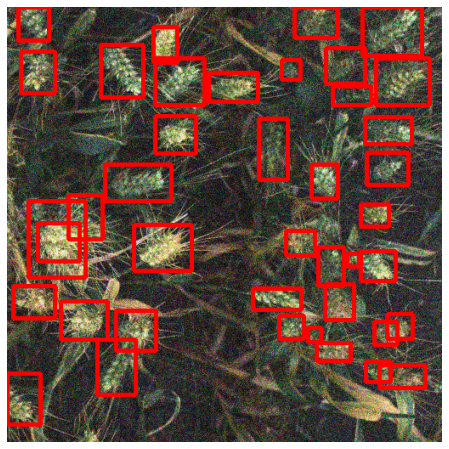

In [30]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

idx = 2
boxes = targets[idx]['boxes'].cpu().numpy().astype(int)
sample = images[idx].permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    sample = cv2.rectangle(sample.copy(), (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# 3.Точная настройка модели

### Определение модели

Faster R-CNN - это модель, которая предсказывает как ограничительные рамки, так и оценки классов для потенциальных объектов на изображении.


Давайте объясним, как работает эта архитектура, поскольку RCNN состоит из 3 частей

1. Часть 1: Слои свертки: Архитектура CNN формируется стеком отдельных слоев, которые преобразуют входной объем в выходной объем (например, хранящий оценки класса) с помощью дифференцируемой функции.Сверточные сети были вдохновлены биологическими процессами в том смысле, что структура связей между нейронами напоминает организацию зрительной коры головного мозга животных. Отдельные нейроны коры головного мозга реагируют на стимулы только в ограниченной области поля зрения, известной как рецептивное поле. Рецептивные поля разных нейронов частично перекрываются таким образом, что они охватывают все поле зрения.

2. Часть 2: Сеть предложения региона (RPN): RPN - это небольшая нейронная сеть, скользящая по последней карте объектов слоев свертки и предсказывающая, есть объект или нет, а также предсказывающая ограничивающую рамку этих объектов.

3. Часть 3: Предсказание классов и ограничивающих рамок: Теперь мы используем другую полностью связанную нейронную сеть, которая принимает в качестве inpt области, предложенные RPN, и предсказывает класс объекта (классификация) и ограничивающие рамки (регрессия).

In [37]:
# загрузить модель; предварительно обученную на COCO
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, pretrained_backbone=True)

/Users/keleas/miniconda3/envs/general/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/keleas/miniconda3/envs/general/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/keleas/miniconda3/envs/general/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/Users/keleas/min

In [38]:
# класс № 1 (пшеница) + фон
num_classes = 2  

# получить количество входных объектов для классификатора
in_features = model.roi_heads.box_predictor.cls_score.in_features

# замените предварительно подготовленную головку на новую
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [39]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

### Давайте потренируем нашу модель

In [43]:
device = 'cpu'

In [44]:
model.train()
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

num_epochs = 1

loss_hist = Averager()
itr = 1

In [46]:
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values()).type(torch.float32)
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

  0%|                                                                       | 0/677 [00:01<?, ?it/s]


KeyboardInterrupt: 

# 4. Предсказание

### Давайте загрузим тестовые данные

In [47]:
test_dataset = WheatDataset(submit, test_dir, get_valid_transforms(), False)

In [48]:
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Установите пороговое значение для прогнозирования ограничивающей рамки

In [49]:
detection_threshold = 0.45

In [51]:
results = []
model.eval()

for images, _, image_ids in tqdm(test_data_loader):    

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()    ##Formate of the output's box is [Xmin,Ymin,Xmax,Ymax]
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32) #Compare the score of output with the threshold and
        scores = scores[scores >= detection_threshold]                    #slelect only those boxes whose score is greater
                                                                          # than threshold value
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]         
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]         #Convert the box formate to [Xmin,Ymin,W,H]

100%|█████████████████████████████████████████████████████████████████| 2/2 [00:11<00:00,  5.99s/it]


In [53]:
sample = images[1].permute(1, 2, 0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

### Давайте построим некоторые из наших прогнозов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


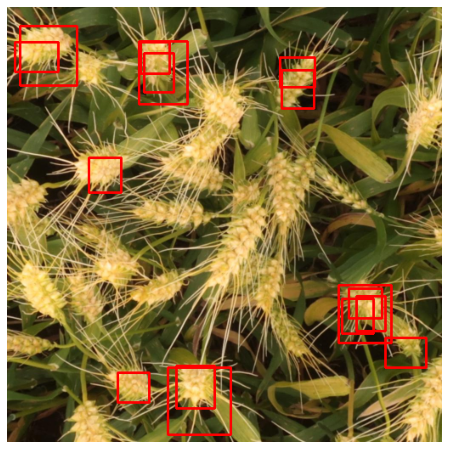

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    sample = cv2.rectangle(sample.copy(),
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)